In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
from itertools import accumulate

# Principal Component Analysis (PCA) of the Canadian Yield Curve

## Canadian Yield Curve Data

We can get data on the Canadian Yield curve from the Bank of Canada at the following link: https://www.bankofcanada.ca/rates/interest-rates/

I will be using the Treasury Bill yields for short term, and Bond yields for long term rates.

In [ ]:
bonds = pd.read_csv('/content/bond_yields_benchmark.csv').set_index('date')
bills = pd.read_csv('/content/tbill_wednesday.csv').set_index('date')
yields = pd.merge(bills, bonds, left_index=True, right_index=True)
yields.head()

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,LONG
date,,,,,,,,,,
2001-01-03,5.31,5.34,5.26,5.18,5.11,5.17,5.28,5.33,5.43,5.63
2001-01-10,5.18,5.24,5.14,5.04,5.00,5.08,5.21,5.27,5.41,5.68
2001-01-17,5.21,5.26,5.18,5.13,5.06,5.12,5.24,5.29,5.41,5.66
2001-01-24,5.19,5.23,5.15,5.10,5.08,5.14,5.30,5.37,5.51,5.78
2001-01-31,5.17,5.11,5.00,4.90,4.88,4.96,5.14,5.20,5.39,5.72


In the plot below, we can see the yield by term maturity of historical Canadian rates. Although we have all experienced higher rates and hikes throughout the past few years, you can observe we are in the same range as rates were around in 2002.

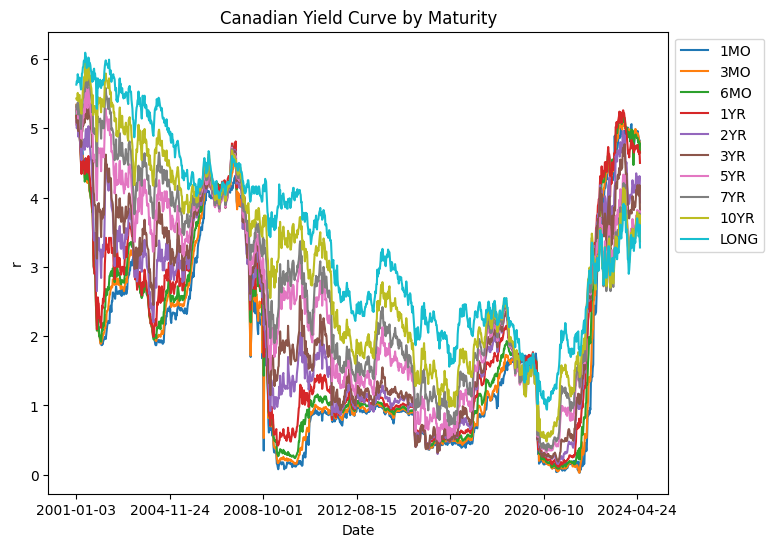

In [ ]:
yields.plot(figsize=(8, 6))
plt.title('Canadian Yield Curve by Maturity')
plt.xlabel('Date')
plt.ylabel('r')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc=2)

Just to explore this abit further, we can look at the yield curve by date at the beginning of the time period (2001-01-03) and compare it to the most recent data (2024-06-05).

The most noticable difference is obviously the inverted yield cuve that we are currently in. In 2001 we have the longer term bonds provide investors with the highest yield. In 2024 we have the opposite, that 1MO Treasury Bills have higher yield than long term bonds. This is quite often quoted as a sign of a recession in an economy.

In the timeseries graph above, it can be seen that this inversion happens around mid 2022 when long term bonds drop to the lowest yield.

In [ ]:
yields.iloc[[0, -1]]

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,LONG
date,,,,,,,,,,
2001-01-03,5.31,5.34,5.26,5.18,5.11,5.17,5.28,5.33,5.43,5.63
2024-06-05,4.71,4.66,4.65,4.50,3.93,3.79,3.41,3.37,3.38,3.28


Using splines we can interpolate the data between these maturities to see the difference in yield curves between 2001 and today more clearly. I am using cubic splines to interpolate.

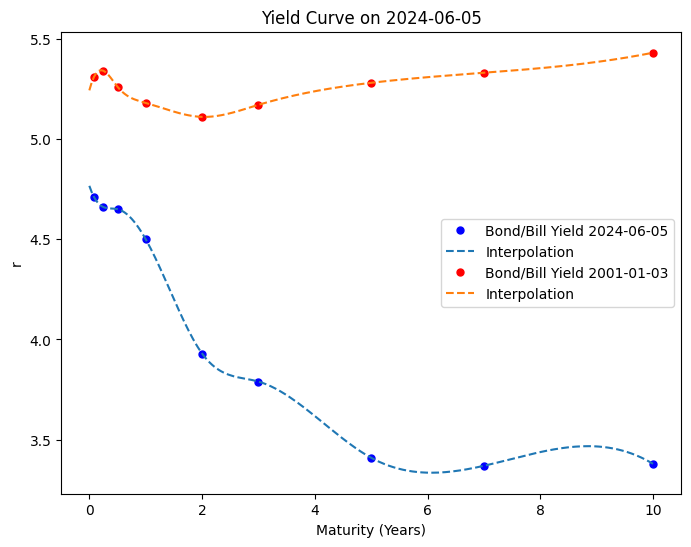

In [ ]:
time = np.array((1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10))
oldest_yield = np.array((5.31,	5.34,	5.26,	5.18,	5.11,	5.17,	5.28,	5.33,	5.43))
latest_yield = np.array((4.71,	4.66,	4.65,	4.5,	3.93,	3.79,	3.41,	3.37,	3.38))
spline_latest = splrep(time, latest_yield, k=3)  # 2-Spline
spline_oldest = splrep(time, oldest_yield, k=3)  # 2-Spline
maturities = np.linspace(0.0, 10.0, 240)
inter_lat = splev(maturities, spline_latest, der=0)  # Interpolation
inter_old = splev(maturities, spline_oldest, der=0)  # Interpolation

plt.figure(figsize=(8, 6))
plt.plot(time, latest_yield, "b.", markersize="10", label="Bond/Bill Yield 2024-06-05")
plt.plot(maturities, inter_lat, "--", markersize="10", label="Interpolation")
plt.plot(time, oldest_yield, "r.", markersize="10", label="Bond/Bill Yield 2001-01-03")
plt.plot(maturities, inter_old, "--", markersize="10", label="Interpolation")
plt.xlabel("Maturity (Years)")
plt.ylabel("r")
plt.title("Yield Curve on 2024-06-05")
plt.legend()
plt.show()

## Principal Component Analysis

Principal Component Analysis is a technique which is often applied to yield curve modeling. It helps in reducing the dimensionality of a dataset by identifying the most important features. In this case, it would be identifying the most important yield curve maturities. It does this by creating 'principal components' which are essentially linear combinations of the yield curve maturities that explain the most variation within the data.

With PCA it is essential to standardize the data beforehand, so we will start with that.

In [ ]:
df_std = (yields - yields.mean()) / yields.std()
df_std.head()

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,LONG
date,,,,,,,,,,
2001-01-03,2.391172,2.342363,2.227461,2.109941,2.102677,2.058145,2.007472,1.896307,1.790061,1.725708
2001-01-10,2.302664,2.274882,2.146427,2.014410,2.023252,1.993133,1.955793,1.852396,1.775350,1.764075
2001-01-17,2.323089,2.288378,2.173438,2.075823,2.066575,2.022027,1.977941,1.867033,1.775350,1.748729
2001-01-24,2.309472,2.268134,2.153180,2.055352,2.081016,2.036474,2.022237,1.925581,1.848907,1.840810
2001-01-31,2.295855,2.187157,2.051888,1.918880,1.936606,1.906452,1.904115,1.801167,1.760638,1.794769


Using the standardized data, we can compute the principal components. The first principal component explains 88.10% of the variance within the data. The second explains 11.01% and the third 0.73%. Bringing the cumulative explained variance to 99.83% for the first three principal components. This is pretty comprehensive so we will stick to investigating the first three, although you could get away with only two as they still explain over 99% of variance in the data.

In [ ]:
cov_matrix_array = np.array(np.cov(df_std, rowvar=False))
cov_df = pd.DataFrame(cov_matrix_array, columns=yields.columns, index=yields.columns)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_array)
df_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})
columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]
df_eigvec = pd.DataFrame(eigenvectors, columns=columns, index=yields.columns)
explained_variance = [round(variance / sum(eigenvalues), 3) for variance in eigenvalues]
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])
df_eigval["Cumulative Explained Variance"] = list(accumulate(df_eigval["Explained proportion"]))
df_eigval.style.format({"Explained proportion": "{:.2%}"})
df_eigval.style.format({"Cumulative Explained Variance": "{:.2%}"})

,Eigenvalues,Explained proportion,Cumulative Explained Variance
0,8.809829,0.880983,88.10%
1,1.100745,0.110075,99.11%
2,0.072500,0.007250,99.83%
3,0.009465,0.000946,99.93%
4,0.003199,0.000320,99.96%
5,0.001393,0.000139,99.97%
6,0.000352,0.000035,99.97%
7,0.001048,0.000105,99.99%
8,0.000778,0.000078,99.99%
9,0.000692,0.000069,100.00%


Please see the values of the components below.

In [ ]:
df_eigvec[['PC1', 'PC2', 'PC3']]

,PC1,PC2,PC3
1MO,-0.310383,0.348279,0.456800
3MO,-0.313216,0.340839,0.317431
6MO,-0.316020,0.327473,0.097299
1YR,-0.321449,0.276749,-0.187870
2YR,-0.332885,0.098298,-0.408441
3YR,-0.334661,-0.016439,-0.392592
5YR,-0.327127,-0.213470,-0.270858
7YR,-0.318731,-0.305433,-0.080362
10YR,-0.304907,-0.403418,0.117062
LONG,-0.279249,-0.516879,0.480968


The first three principal components of a series show specific things about the timeseries.

*   PC 1 - corresponds to the 'level' of the timeseries.
*   PC 2 - corresponds to the slope or flatness of the timeseries.
*   PC 3 - corresponds to the curvature of the timeseries.

The amounts we get for each tenor give an indication of how much each tenor affects these properties.

<ipython-input-72-2646502140b6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(yields.columns, rotation="vertical")


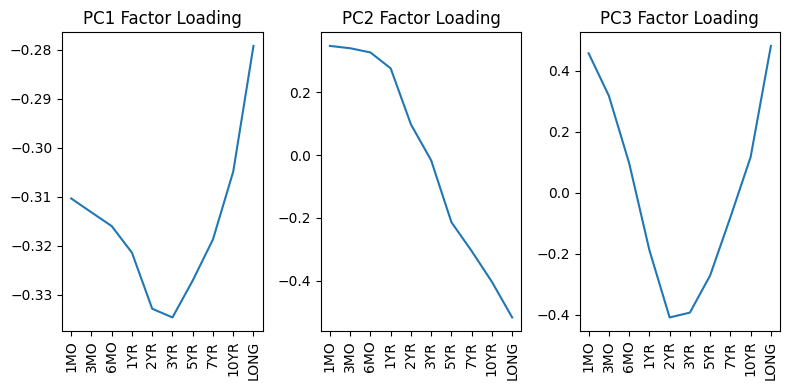

In [ ]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(8)
fig.set_figheight(4)
axs[0].plot(df_eigvec["PC1"].index, df_eigvec["PC1"].values)
axs[0].set_title('PC1 Factor Loading')
axs[0].set_xticks(np.arange(10))
axs[0].set_xticklabels(yields.columns, rotation="vertical")
axs[1].plot(df_eigvec["PC2"].index, df_eigvec["PC2"].values)
axs[1].set_title('PC2 Factor Loading')
axs[0].set_xticks(np.arange(10))
axs[1].set_xticklabels(yields.columns, rotation="vertical")
axs[2].plot(df_eigvec["PC3"].index, df_eigvec["PC3"].values)
axs[2].set_title('PC3 Factor Loading')
axs[2].set_xticks(np.arange(10))
axs[2].set_xticklabels(yields.columns, rotation="vertical")
plt.tight_layout()
plt.show()

Looking at the factor loadings above, we can see that the 'level' of the timeseries corresponds greater with short term rates, with the greatest influence being the 2 and 3 year points.

The slope of the yield curve corresponds positivley with short term rates and has a stronger negative relationship with long term rates.

For the third principal component, we have that the 1 Month and Long term rates affect the curvature positivley, while the 2 and 3 year rates affect the curvature negativley.

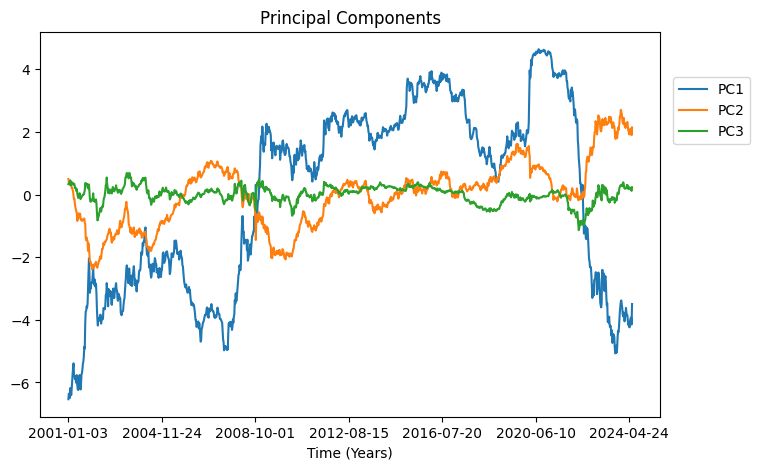

In [ ]:
principal_components = df_std.dot(eigenvectors)
principal_components.columns = df_eigvec.columns
principal_components.plot(y=["PC1", "PC2", "PC3"], figsize=(8, 5))
plt.xlabel("Time (Years)")
plt.title("Principal Components")
plt.legend(["PC1", "PC2", "PC3"], bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

Viewing the principal components over time is also an interesting analysis. Looking back at the first chart we produced, it can be seen that these components do capture the information shown in the Canadian Yield curve.

The first principal component (inversley) catures the level the yield curve is at. The second principal component captures the slope at which the yield curve increases/decreases. Furthermore, while the third principal component is largely flat, it does spike around mid 2022 where the yield curve inverses.

PCA is a useful yield curve analysis technique which allows you to learn more about the rates which affect the yield curve position and dynamics in more detail. Additionally, the output of PCA can be used as a lower-dimensional input for many statistical learning techniques to improve computational efficiency.

**References:**
*   Oprea, Andreea. "The Use of Principal Component Analysis (PCA) in Building Yield Curve Scenarios and Identifying Relative-Value Trading Opportunities on the Romanian Government Bond Market." Journal of Risk and Financial Management, vol. 15, no. 6, 2022, https://www.mdpi.com/1911-8074/15/6/247.